## Imports

In [5]:
# data manupulation
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

# stats
import statsmodels.api as sm
from scipy.stats import boxcox # this can't handle negative values
from scipy.stats import yeojohnson # this ia extention to boxcox

# encoder and scaling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer

# utility
import os
from typing import List
import string
import time
import re
import ast
import warnings
warnings.filterwarnings('ignore')

In [6]:
DATA_DIR = os.path.join(os.getcwd(), "Dataset", "1_clean_data")
PATH = os.path.join(DATA_DIR, "clean_train_v1.csv")

In [7]:
train_df = pd.read_csv(PATH)

In [8]:
df = train_df.copy()

In [9]:
df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass,Sex,Ticket,Cabin,Embarked,Name
0,1,0,22.0,1,0,7.2500,3,male,A/5 21171,Missing,S,"braund, mr. owen harris"
1,2,1,38.0,1,0,71.2833,1,female,PC 17599,C85,C,"cumings, mrs. john bradley (florence briggs th..."
2,3,1,26.0,0,0,7.9250,3,female,STON/O2. 3101282,Missing,S,"heikkinen, miss. laina"
3,4,1,35.0,1,0,53.1000,1,female,113803,C123,S,"futrelle, mrs. jacques heath (lily may peel)"
4,5,0,35.0,0,0,8.0500,3,male,373450,Missing,S,"allen, mr. william henry"


In [10]:
TARGET_COL = ["Survived"]
ID_COL = ["PassengerId"]
TEXT_FEATURES = ["Name"]
CAT_FEATURES = [col for col in df.columns if df[col].dtype == "O" if col not in TARGET_COL+ID_COL+TEXT_FEATURES]
NUM_FEATURES = [col for col in df.columns if df[col].dtype != "O" if col not in TARGET_COL+ID_COL+TEXT_FEATURES]

In [11]:
TARGET_DATA = df[TARGET_COL].copy()
ID_DATA = df[ID_COL].copy()

In [12]:
print("id column: ", ID_COL)
print("target column: ", TARGET_COL)
print("categorical columns: ", CAT_FEATURES)
print("numerical columns: ", NUM_FEATURES)
print("text features: ", TEXT_FEATURES)

id column:  ['PassengerId']
target column:  ['Survived']
categorical columns:  ['Sex', 'Ticket', 'Cabin', 'Embarked']
numerical columns:  ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
text features:  ['Name']


## Correcting feature categarization : Manually

In [13]:
# TARGET_COL = ["Survived"]
# ID_COL = ["PassengerId"]
# TEXT_FEATURES = ["Name", "Name_Lower"]
CAT_FEATURES = ['Sex', 'Ticket', 'Cabin', 'Embarked']
NUM_FEATURES = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

### Functions to use

In [14]:
class DataEncoding:

    def __init__(self, clean_df: pd.DataFrame):
        self.original_df = clean_df.copy()
        self.df = clean_df.copy() # here will perform our encodings
        self.trans_tech = ["Logarithmic", "Logarithmic_10", "Exponential", "Exponential_2", "Power", "Square", "Cubic"]
        self.scale_tech = ["Normal_l1", "Normal_l2", "MaxAbcScaler", "Robust", "MinMax", "Standard"]

    # label encoding
    def lable_encode(self, input_col:str, output_col:str):
        """
        label encodes the passed column from dataframe
        and adds encoded data to dataframe under new columns
        name reffred to variable `output_col`.

        Args:
            input_col (str): column name that exists in dataframe.
            output_col (str): column name for encoded data.

        Returns:
            None

        Raises:
            ValueError: If the input_col `string` is empty.
            ValueError: If the output_col `string` is empty.

        Example:
            >>> 
        """
        label_encode = LabelEncoder()
        label_encode.fit(self.df[input_col])
        self.df[output_col] = label_encode.transform(self.df[input_col])
        print(f"Applied Label Encoded : {input_col} --> {output_col}")

    # ordinal encoding
    def ordinal_encode(self, input_col:str, output_col:str, categories=List[str]) -> None:
        """
        ordinally encodes the passed column using categories from dataframe
        and adds encoded data to dataframe under new columns
        name reffred to variable `output_col`.

        Args:
            input_col (str): column name that exists in dataframe.
            output_col (str): column name for encoded data.
            cotegories (list): list of all unique values from input col.

        Returns:
            None

        Raises:
            ValueError: If the input_col `string` is empty.
            ValueError: If the output_col `string` is empty.

        Example:
            >>> 
        """
        if len(categories) > 0:
            ordinal_encod = OrdinalEncoder(categories=[categories])
        else:
            ordinal_encod = OrdinalEncoder(categories=[self.df[input_col].unique().tolist()])
        self.df[output_col] = ordinal_encod.fit_transform(self.df[[input_col]])
        print(f"Applied Ordinal Encoded : {input_col} --> {output_col}")

    # onehot encoding
    def onehot_encode(self, input_col:str, output_col_initials:str) -> None:
        """
        applies one hot encoding on passed `input_col`
        an renames all onehot encoded columns with 
        initials with `output_col_initials`.

        Args:
            input_col (str): column name that exists in dataframe.
            output_col_initials (str): column name for encoded data.

        Returns:
            None

        Raises:
            ValueError: If the input_col `string` is empty.
            ValueError: If the output_col_initials `string` is empty.

        Example:
            >>> 
        """
        if len(output_col_initials) == 0:
            output_col_initials = input_col
        # initalized encoder
        onehot_encode = OneHotEncoder()
        # applying encoding
        onehot_encoded = onehot_encode.fit_transform(self.df[[input_col]]).toarray()

        # Create a DataFrame for the encoded data
        df_encoded = pd.DataFrame(onehot_encoded, columns=onehot_encode.get_feature_names_out([output_col_initials]))

        # Concatenate with original DataFrame
        self.df = pd.concat([self.df, df_encoded], axis=1)
        print(f"OneHotEncoder Applied on : {input_col}")

    def map_custom_encoding(self, input_col:str, output_col:str, encoding:dict) -> None:
        # Apply custom encoding using map
        self.df[output_col] = self.df[input_col].map(encoding)
        print(f"Applied Custom Encoded : {input_col} --> {output_col}")

    def feature_tranformation(self, input_col:str, type_of_trans: str):
        if type_of_trans == "Logarithmic":
            self.df[input_col+"_Log"] = np.log(self.df[input_col])
        elif type_of_trans == "Logarithmic_10": # base 10
            self.df[input_col+"_Log_10"] = np.log10(self.df[input_col])
        elif type_of_trans == "Exponential":
            self.df[input_col+"_Exp"] = np.exp(self.df[input_col])
        elif type_of_trans == "Exponential_2": # power 2
            self.df[input_col+"_Exp_2"] = np.exp2(self.df[input_col])
        elif type_of_trans == "Power": # removed boxcox
            transformed_data, _ = yeojohnson(self.df[input_col])
            self.df[input_col+"_Power"] = transformed_data
        elif type_of_trans == "Square":
            self.df[input_col+"_Squr"] = np.power(self.df[input_col], 2)
        elif type_of_trans == "Cubic":
            self.df[input_col+"_Cube"] = np.power(self.df[input_col], 3)
        else:
            print(f"No transformation applied: {input_col}")
            # self.df[input_col] = self.df[input_col]

    def feature_scaling(self, input_col:str, type_of_scale:str):
        if type_of_scale == "Normal_l1":
            scaler = Normalizer(norm='l1')
            self.df[input_col+"_Norm_l1"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "Normal_l2":
            scaler = Normalizer(norm='l2')
            self.df[input_col+"_Norm_l2"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "MaxAbcScaler":
            scaler = MaxAbsScaler()
            self.df[input_col+"_MaxAbs"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "Robust":
            scaler = RobustScaler()
            self.df[input_col+"_Robust"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "MinMax":
            scaler = MinMaxScaler()
            self.df[input_col+"_MinMax"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "Standard":
            scaler = StandardScaler()
            self.df[input_col+"_Standard"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

    def transform_with_all_technique(self, input_col:str):
        for tech in self.trans_tech:
            self.feature_tranformation(input_col, tech)
            print(f"Transformed {input_col} with : {tech}")

    def scaling_with_all_technique(self, input_col:str):
        for tech in self.scale_tech:
            self.feature_scaling(input_col, tech)
            print(f"Scaled {input_col} with : {tech}")            

### Example to use functions

In [15]:
my_df = pd.DataFrame(
    {
        "label": ['male', 'female', 'male', 'female', 'male', 'female', 'female', 'male', 'male', 'female'],
        "ordinal": ['jan', 'feb', 'march', 'march', 'march', 'feb', 'feb', 'jan', 'feb', 'jan'] ,
        "onehot": ["violate", "indigo", "blue", "green", "orange", "yellow", "red", "white", "black", "brown"],
        "numerical": [np.random.randint(0, 10000) for _ in range(10)]
    }
)

encode_obj = DataEncoding(my_df)

#### Categorical Transformations

In [16]:
encode_obj.lable_encode("label", "label_encode")

Applied Label Encoded : label --> label_encode


In [17]:
encode_obj.ordinal_encode("ordinal", "ordinal_encode", ['march', 'feb', 'jan'])

Applied Ordinal Encoded : ordinal --> ordinal_encode


In [18]:
encode_obj.onehot_encode("onehot", "onehot")

OneHotEncoder Applied on : onehot


In [19]:
encode_obj.df.head()

,label,ordinal,onehot,numerical,label_encode,ordinal_encode,onehot_black,onehot_blue,onehot_brown,onehot_green,onehot_indigo,onehot_orange,onehot_red,onehot_violate,onehot_white,onehot_yellow
0,male,jan,violate,3957,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,female,feb,indigo,7768,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,male,march,blue,8307,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,female,march,green,3627,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,male,march,orange,7169,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Numerical Transformations

In [20]:
encode_trans = DataEncoding(my_df)

In [21]:
encode_trans.original_df.head()

,label,ordinal,onehot,numerical
0,male,jan,violate,3957
1,female,feb,indigo,7768
2,male,march,blue,8307
3,female,march,green,3627
4,male,march,orange,7169


In [22]:
encode_trans.transform_with_all_technique("numerical")

Transformed numerical with : Logarithmic
Transformed numerical with : Logarithmic_10
Transformed numerical with : Exponential
Transformed numerical with : Exponential_2
Transformed numerical with : Power
Transformed numerical with : Square
Transformed numerical with : Cubic


In [23]:
encode_trans.df.head()

,label,ordinal,onehot,numerical,numerical_Log,numerical_Log_10,numerical_Exp,numerical_Exp_2,numerical_Power,numerical_Squr,numerical_Cube
0,male,jan,violate,3957,8.283241,3.597366,inf,inf,440.364402,15657849,61958108493
1,female,feb,indigo,7768,8.957768,3.890309,inf,inf,702.453633,60341824,468735288832
2,male,march,blue,8307,9.024854,3.919444,inf,inf,735.828790,69006249,573234910443
3,female,march,green,3627,8.196161,3.559548,inf,inf,414.584002,13155129,47713652883
4,male,march,orange,7169,8.877521,3.855459,inf,inf,664.509923,51394561,368447607809


#### Numerical Scaling and Normalization

In [24]:
encode_scl = DataEncoding(my_df)

In [25]:
encode_scl.original_df.head()

,label,ordinal,onehot,numerical
0,male,jan,violate,3957
1,female,feb,indigo,7768
2,male,march,blue,8307
3,female,march,green,3627
4,male,march,orange,7169


In [26]:
encode_scl.scaling_with_all_technique("numerical")

Scaled numerical with : Normal_l1
Scaled numerical with : Normal_l2
Scaled numerical with : MaxAbcScaler
Scaled numerical with : Robust
Scaled numerical with : MinMax
Scaled numerical with : Standard


In [27]:
encode_scl.df.head()

,label,ordinal,onehot,numerical,numerical_Norm_l1,numerical_Norm_l2,numerical_MaxAbs,numerical_Robust,numerical_MinMax,numerical_Standard
0,male,jan,violate,3957,1.0,1.0,0.476345,-0.188917,0.469447,-0.264191
1,female,feb,indigo,7768,1.0,1.0,0.935115,0.532488,0.934260,1.002581
2,male,march,blue,8307,1.0,1.0,1.000000,0.634518,1.000000,1.181744
3,female,march,green,3627,1.0,1.0,0.436620,-0.251384,0.429199,-0.373882
4,male,march,orange,7169,1.0,1.0,0.863007,0.419100,0.861203,0.803474


# Feature Engineering Version 1

# Handeling Text Feature

In [28]:
TEXT_FEATURES

['Name']

In [29]:
# copying text features
TEXT_DF = df[TEXT_FEATURES].copy()

In [30]:
encode_text = DataEncoding(TEXT_DF)

In [31]:
encode_text.df.head()

,Name
0,"braund, mr. owen harris"
1,"cumings, mrs. john bradley (florence briggs th..."
2,"heikkinen, miss. laina"
3,"futrelle, mrs. jacques heath (lily may peel)"
4,"allen, mr. william henry"


In [32]:
TEXT_DF["Name"].apply(lambda x: len(x.split()))

0      4
1      7
2      3
3      7
4      4
      ..
886    3
887    4
888    5
889    4
890    3
Name: Name, Length: 891, dtype: int64

In [33]:
# number of letters in name
encode_text.df["Name_Words"] = TEXT_DF["Name"].apply(lambda x: len(x.split()))
# number of words
encode_text.df["Name_Length"] = TEXT_DF["Name"].apply(lambda x: len(x))
# keeping only 

In [34]:
encode_text.df.head()

,Name,Name_Words,Name_Length
0,"braund, mr. owen harris",4,23
1,"cumings, mrs. john bradley (florence briggs th...",7,51
2,"heikkinen, miss. laina",3,22
3,"futrelle, mrs. jacques heath (lily may peel)",7,44
4,"allen, mr. william henry",4,24


- Here we are trying to get name initials from those names line `Mr., Mrs, Miss., Dr.` .,etc

In [35]:
TEXT_DF["Name"][0]

'braund, mr. owen harris'

In [36]:
encode_text.df["Name_Init"] = TEXT_DF["Name"].apply(lambda word: list(filter(lambda word: word.endswith('.'), word.split()))[0][:-1])

In [37]:
encode_text.df.head()

,Name,Name_Words,Name_Length,Name_Init
0,"braund, mr. owen harris",4,23,mr
1,"cumings, mrs. john bradley (florence briggs th...",7,51,mrs
2,"heikkinen, miss. laina",3,22,miss
3,"futrelle, mrs. jacques heath (lily may peel)",7,44,mrs
4,"allen, mr. william henry",4,24,mr


In [38]:
encode_text.df[["Name_Init"]].describe().T

,count,unique,top,freq
Name_Init,891,17,mr,517


In [39]:
name_init = [i[0] for i in encode_text.df[["Name_Init"]].value_counts().keys()]

<Axes: xlabel='count', ylabel='Name_Init'>

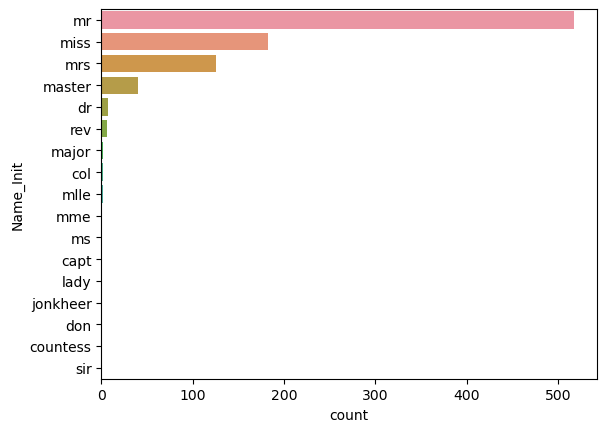

In [40]:
sns.countplot(data=encode_text.df, y="Name_Init", order=name_init)

### Feature Encoding

In [41]:
# name initials
name_init = encode_text.df["Name_Init"].value_counts(ascending=False).keys().tolist()
print(name_init)

['mr', 'miss', 'mrs', 'master', 'dr', 'rev', 'mlle', 'major', 'col', 'countess', 'capt', 'ms', 'sir', 'lady', 'mme', 'don', 'jonkheer']


In [42]:
encode_text.lable_encode("Name_Init", "Name_Init_labelencode")
encode_text.ordinal_encode("Name_Init","Name_Init_ordinalencode", name_init)
encode_text.onehot_encode("Name_Init","Name_Init")

Applied Label Encoded : Name_Init --> Name_Init_labelencode
Applied Ordinal Encoded : Name_Init --> Name_Init_ordinalencode
OneHotEncoder Applied on : Name_Init


In [43]:
TEXT_DF = encode_text.df.copy()

In [44]:
TEXT_DF.head()

,Name,Name_Words,Name_Length,Name_Init,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_capt,Name_Init_col,Name_Init_countess,Name_Init_don,...,Name_Init_major,Name_Init_master,Name_Init_miss,Name_Init_mlle,Name_Init_mme,Name_Init_mr,Name_Init_mrs,Name_Init_ms,Name_Init_rev,Name_Init_sir
0,"braund, mr. owen harris",4,23,mr,12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,"cumings, mrs. john bradley (florence briggs th...",7,51,mrs,13,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,"heikkinen, miss. laina",3,22,miss,9,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"futrelle, mrs. jacques heath (lily may peel)",7,44,mrs,13,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,"allen, mr. william henry",4,24,mr,12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [45]:
TEXT_COLS_ENCODED = [col for col in TEXT_DF.columns if col not in ["Name", "Name_Init"]]

In [46]:
TEXT_COLS_ENCODED

['Name_Words',
 'Name_Length',
 'Name_Init_labelencode',
 'Name_Init_ordinalencode',
 'Name_Init_capt',
 'Name_Init_col',
 'Name_Init_countess',
 'Name_Init_don',
 'Name_Init_dr',
 'Name_Init_jonkheer',
 'Name_Init_lady',
 'Name_Init_major',
 'Name_Init_master',
 'Name_Init_miss',
 'Name_Init_mlle',
 'Name_Init_mme',
 'Name_Init_mr',
 'Name_Init_mrs',
 'Name_Init_ms',
 'Name_Init_rev',
 'Name_Init_sir']

In [47]:
ENCODED_TEXT_DATA = TEXT_DF[TEXT_COLS_ENCODED].copy()

In [48]:
ENCODED_TEXT_DATA.head()

,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_capt,Name_Init_col,Name_Init_countess,Name_Init_don,Name_Init_dr,Name_Init_jonkheer,...,Name_Init_major,Name_Init_master,Name_Init_miss,Name_Init_mlle,Name_Init_mme,Name_Init_mr,Name_Init_mrs,Name_Init_ms,Name_Init_rev,Name_Init_sir
0,4,23,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,7,51,13,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,22,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,44,13,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,24,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Feature Engineering Summary:

- `Name` -> `Name_Words`, `Name_Length`
- `Name` seperated names initials, and applied encodings on it

# Handeling Categorical Feature

In [49]:
CAT_FEATURES

['Sex', 'Ticket', 'Cabin', 'Embarked']

In [50]:
# copying categorical features
CAT_DF = df[CAT_FEATURES].copy()

In [51]:
CAT_DF.head()

,Sex,Ticket,Cabin,Embarked
0,male,A/5 21171,Missing,S
1,female,PC 17599,C85,C
2,female,STON/O2. 3101282,Missing,S
3,female,113803,C123,S
4,male,373450,Missing,S


### Feature Engineering : Sex

In [52]:
encode_cat = DataEncoding(CAT_DF)

#### Feature Encoding : Sex

In [53]:
encode_cat.lable_encode("Sex", "Sex_labelencode")

Applied Label Encoded : Sex --> Sex_labelencode


In [54]:
encode_cat.df.head()

,Sex,Ticket,Cabin,Embarked,Sex_labelencode
0,male,A/5 21171,Missing,S,1
1,female,PC 17599,C85,C,0
2,female,STON/O2. 3101282,Missing,S,0
3,female,113803,C123,S,0
4,male,373450,Missing,S,1


### Feature Engineering : Embarked

<Axes: xlabel='count', ylabel='Embarked'>

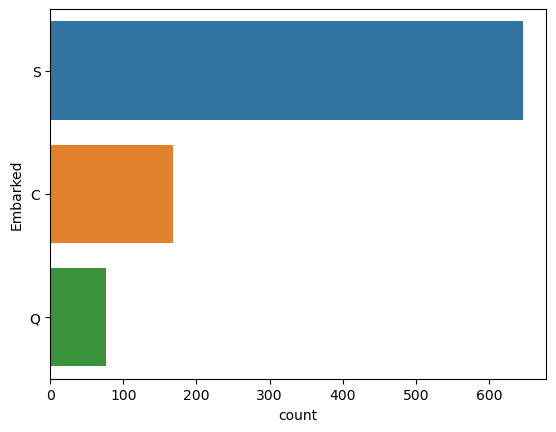

In [55]:
sns.countplot(data=CAT_DF, y="Embarked")

- Embarked - basically stations or can say stops from where passengers onboarded the ship

`S = Southampton [0], C = Cherbourg [1], Q = Queenstown [2], `

#### Feature Encoding : Embarked

In [56]:
encode_cat.lable_encode("Embarked", "Embraked_labelencoded")

Applied Label Encoded : Embarked --> Embraked_labelencoded


In [57]:
encode_cat.ordinal_encode("Embarked", "Embarked_ordinalencode", ['S', 'C', 'Q'])

Applied Ordinal Encoded : Embarked --> Embarked_ordinalencode


In [58]:
encode_cat.onehot_encode("Embarked", "Embarked")

OneHotEncoder Applied on : Embarked


In [59]:
CAT_DF = encode_cat.df.copy()

In [60]:
CAT_DF.head()

,Sex,Ticket,Cabin,Embarked,Sex_labelencode,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S
0,male,A/5 21171,Missing,S,1,2,0.0,0.0,0.0,1.0
1,female,PC 17599,C85,C,0,0,1.0,1.0,0.0,0.0
2,female,STON/O2. 3101282,Missing,S,0,2,0.0,0.0,0.0,1.0
3,female,113803,C123,S,0,2,0.0,0.0,0.0,1.0
4,male,373450,Missing,S,1,2,0.0,0.0,0.0,1.0


In [61]:
CAT_COLS_ENCODED = [col for col in CAT_DF.columns if col not in CAT_FEATURES]
CAT_COLS_ENCODED

['Sex_labelencode',
 'Embraked_labelencoded',
 'Embarked_ordinalencode',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [62]:
ENCODED_CAT_DATA =  CAT_DF[CAT_COLS_ENCODED].copy()

In [63]:
ENCODED_CAT_DATA.head()

,Sex_labelencode,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S
0,1,2,0.0,0.0,0.0,1.0
1,0,0,1.0,1.0,0.0,0.0
2,0,2,0.0,0.0,0.0,1.0
3,0,2,0.0,0.0,0.0,1.0
4,1,2,0.0,0.0,0.0,1.0


## Feature Engineering Summary:

- `Sex` -> label encoded
- `Embarked` -> label encoded, ordinal and onehot encoded.

# Handeling Numerical Feature

In [64]:
def comparision_plot(df:pd.DataFrame, input_col:str, compare_col:str) -> None:
    sns.kdeplot(data=df, x=input_col, alpha=0.5,  fill=True, linewidth=0, label=input_col, common_norm=True)
    sns.kdeplot(data=df, x=compare_col, alpha=0.5,  fill=True, linewidth=0, label=compare_col, common_norm=True)
    plt.legend()
    plt.show()

In [65]:
NUM_FEATURES

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [66]:
# copying numerical features
NUM_DF = df[NUM_FEATURES].copy()

In [67]:
NUM_DF.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


#### Feature Transformation : Age

In [68]:
# loading data in encoding object
trans_age = DataEncoding(NUM_DF[["Age"]])

# performing all transformations
trans_age.transform_with_all_technique("Age")

# the scaling down data points between 0 and 1
for i in trans_age.df.columns:
    trans_age.feature_scaling(i, "MinMax")

Transformed Age with : Logarithmic
Transformed Age with : Logarithmic_10
Transformed Age with : Exponential
Transformed Age with : Exponential_2
Transformed Age with : Power
Transformed Age with : Square
Transformed Age with : Cubic


In [69]:
trans_age.df.columns

Index(['Age', 'Age_Log', 'Age_Log_10', 'Age_Exp', 'Age_Exp_2', 'Age_Power',
       'Age_Squr', 'Age_Cube', 'Age_MinMax', 'Age_Log_MinMax',
       'Age_Log_10_MinMax', 'Age_Exp_MinMax', 'Age_Exp_2_MinMax',
       'Age_Power_MinMax', 'Age_Squr_MinMax', 'Age_Cube_MinMax'],
      dtype='object')

In [70]:
# ploting data to see shape of distribution
# for i in trans_age.df.columns:
#     if i.endswith('MinMax'):
#         sns.kdeplot(data=trans_age.df, x=i, alpha=0.5,  fill=True, linewidth=0, label=i)
# plt.legend()
# plt.show()

In [71]:
data = []
columns = []
for i in trans_age.df.columns:
    if i.endswith('MinMax'):
        data.append(trans_age.df[i].values)
        columns.append(i)

In [72]:
fig = ff.create_distplot(data, columns, bin_size=.25, show_hist=False)
fig.show()

- Age -> Power Transformation -> Minmax Scaling

In [73]:
# sns.kdeplot(data=trans_age.df, x="Age_MinMax", alpha=0.5,  fill=True, linewidth=0)
# sns.kdeplot(data=trans_age.df, x="Age_Power_MinMax", alpha=0.5,  fill=True, linewidth=0)

#### Feature Transformation : Fare

In [74]:
# loading data in encoding object
trans_fare = DataEncoding(NUM_DF[["Fare"]])

# performing all transformations
trans_fare.feature_tranformation("Fare", "Power")



In [75]:
trans_fare.df.head()

,Fare,Fare_Power
0,7.2500,1.906724
1,71.2833,3.497640
2,7.9250,1.970459
3,53.1000,3.304258
4,8.0500,1.981680


In [76]:
fig = ff.create_distplot([trans_fare.df[col].values for col in trans_fare.df.columns], trans_fare.df.columns, bin_size=.25, show_hist=False)
fig.show()

In [77]:
# performing all scaling
trans_fare.scaling_with_all_technique("Fare_Power")

Scaled Fare_Power with : Normal_l1
Scaled Fare_Power with : Normal_l2
Scaled Fare_Power with : MaxAbcScaler
Scaled Fare_Power with : Robust
Scaled Fare_Power with : MinMax
Scaled Fare_Power with : Standard


In [78]:
# trans_fare.df.head()

In [79]:
data = []
columns = []
for i in trans_fare.df.columns:
    if i.startswith('Fare_Power'):
        arr = trans_fare.df[i].values
        if np.any(np.isinf(arr)) or np.any(np.isnan(arr)):
            print(f"'{i}' contains infs or NaNs")
        else:
            data.append(arr.tolist())
            columns.append(i)
fig = ff.create_distplot(data, columns, bin_size=.25, show_hist=False)
fig.show()

- Fare -> Power Transformation

#### Final Transformations

In [80]:
trans_num = DataEncoding(NUM_DF[["Age", "Fare"]])

In [81]:
trans_num.feature_tranformation("Age", "Power") # power transform
trans_num.feature_scaling("Age_Power", "MinMax") # minmax scaling 
trans_num.feature_tranformation("Fare", "Power") # power transform
# trans_num.feature_scaling("Fare", "MinMax") # minmax scaling

In [82]:
trans_num.df.head()

,Age,Fare,Age_Power,Age_Power_MinMax,Fare_Power
0,22.0,7.2500,13.788503,0.343160,1.906724
1,38.0,71.2833,21.575367,0.542804,3.497640
2,26.0,7.9250,15.820085,0.395247,1.970459
3,35.0,53.1000,20.176650,0.506943,3.304258
4,35.0,8.0500,20.176650,0.506943,1.981680


In [83]:
TRANSFORMED_NUM_DF = pd.concat([NUM_DF.drop(["Age", "Fare"],axis=1), trans_num.df[["Age_Power_MinMax","Fare_Power"]]], axis=1)

In [84]:
TRANSFORMED_NUM_DF.head()

,Pclass,SibSp,Parch,Age_Power_MinMax,Fare_Power
0,3,1,0,0.343160,1.906724
1,1,1,0,0.542804,3.497640
2,3,0,0,0.395247,1.970459
3,1,1,0,0.506943,3.304258
4,3,0,0,0.506943,1.981680


## Feature Engineering Summary:

- `Age` -> Power Transformation -> Minmax scaling
- `Fare`-> Power Transformation

## Data Merging

In [85]:
FINAL_DF = pd.concat([TARGET_DATA,
                    #   ID_COL,
                      ENCODED_TEXT_DATA,
                      ENCODED_CAT_DATA,
                      TRANSFORMED_NUM_DF,
                      ],
                     axis=1)

In [86]:
FINAL_DF.head()

,Survived,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_capt,Name_Init_col,Name_Init_countess,Name_Init_don,Name_Init_dr,...,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Age_Power_MinMax,Fare_Power
0,0,4,23,12,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,3,1,0,0.343160,1.906724
1,1,7,51,13,2.0,0.0,0.0,0.0,0.0,0.0,...,0,1.0,1.0,0.0,0.0,1,1,0,0.542804,3.497640
2,1,3,22,9,1.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,3,0,0,0.395247,1.970459
3,1,7,44,13,2.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,1,1,0,0.506943,3.304258
4,0,4,24,12,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,3,0,0,0.506943,1.981680


In [87]:
FINAL_DF.shape

(891, 33)

## Scaling and Normalization

Scaling entire data 

In [88]:
# for mow not scaling any thing

## Data Export

In [89]:
def export_data(data:pd.DataFrame, file_name:str) -> None:
    # creating folder to store data
    PATH  = os.path.join(os.path.join(os.getcwd(), "Dataset"), "2_processed_data")
    os.makedirs(PATH, exist_ok=True)
    SAVE_PATH  = os.path.join(PATH, file_name)
    data.to_csv(SAVE_PATH, index=False)
    print(f"Saved at: {SAVE_PATH}")

In [90]:
export_data(FINAL_DF, file_name="train_iteratoin4.csv")

Saved at: /Users/rahulshelke/Documents/Data Science/Data Science Projects/Titanic_Problem_Kaggel/Dataset/2_processed_data/train_iteratoin4.csv
